# Example-10: Hankel SVD entropy

In [ ]:
# In this example, an illustration of the Hankel SVD entropy indicator is presented
# This method starts by creating a high-dimensional time embedding for a given time series
# Thus, the time series is represented by a (Hankel) matrix
# Takens's theorem assures that for a large enough matrix, geometric structures can be reconstructed from this matrix
# The entropy of the singular value spectrum is then computed and used as a measure of chaos

# The SVD spectrum can be related to quasi-periodic decomposition
# where regular initial conditions are characterized by fast-decaying amplitudes
# Given a regular initial condition, the corresponding spectrum is expected to decay exponentially fast for quasi-periodic trajectories
# For initial conditions close to resonances, the spectrum decay will be slower.
# The spectrum decay is polynomially slow for chaotic initial conditions

In [1]:
import numpy

import jax
from jax import vmap
from jax import jit

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

from tqdm import tqdm

from tohubohu.util import forward4D
from tohubohu.embedding import construct
from tohubohu import hsvd

In [2]:
# Set data type

jax.config.update("jax_enable_x64", False)

In [3]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [4]:
def observable(orbit):
    qx, qy, px, py = orbit.T
    return 0.5*(qx**2 + px**2) + 0.5*(qy**2 + py**2)

In [5]:
# Set mapping parameters

nux, nuy = 0.168, 0.201
mux, muy = 2*jax.numpy.pi*nux, 2*jax.numpy.pi*nuy
cx, sx, cy, sy = jax.numpy.cos(mux), jax.numpy.sin(mux), jax.numpy.cos(muy), jax.numpy.sin(muy)
mu = 0.0

k = jax.numpy.asarray([cx, sx, cy, sy, mu])

In [6]:
# The following illustrates the embedding construction
# Note, chaos need time to develop
# Hence, there should be relativly large number of map iterations
# But SVD computations is expensive, thus introduction of time delay is required

delay = 8
print(construct(jax.numpy.linspace(0, 2**12 - 1, 2**12), delay=delay, length=2**8 + 1, dimension=2**8 + 1))

[[   0.    8.   16. ... 2032. 2040. 2048.]
 [   8.   16.   24. ... 2040. 2048. 2056.]
 [  16.   24.   32. ... 2048. 2056. 2064.]
 ...
 [2032. 2040. 2048. ... 4064. 4072. 4080.]
 [2040. 2048. 2056. ... 4072. 4080. 4088.]
 [2048. 2056. 2064. ... 4080. 4088. 4095.]]


In [11]:
%%time

# Construct indicator

x = jax.numpy.array([0.0, 0.0, 0.0, 0.0])
fn = jit(hsvd(2**12, forward4D, observable, delay=8, length=2**8 + 1, dimension=2**8, background=1.0E-12))
fn(x, k).block_until_ready()

CPU times: user 159 ms, sys: 3.02 ms, total: 162 ms
Wall time: 72 ms


Array(0.9999999, dtype=float32)

In [12]:
# Set initial grid in (qx, qy) plane

n = 1001

qx = jax.numpy.linspace(0.0, 0.6, n)
qy = jax.numpy.linspace(0.0, 0.6, n)
qs = jax.numpy.stack(jax.numpy.meshgrid(qx, qy, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
ps = jax.numpy.full_like(qs, 1.0E-12)
xs = jax.numpy.hstack([qs, ps])
xs = jax.numpy.array_split(xs, n)

In [13]:
# Evaluate indicator

xb, *xr = xs
fj = jit(vmap(fn, (0, None)))
out = [fj(xb, k)]

for xb in tqdm(xr):
    out.append(fj(xb, k))
out = jax.numpy.concatenate(out)

# Winsorize data

data = numpy.array(out)
data = data.reshape(n, n)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:51<00:00,  2.51s/it]


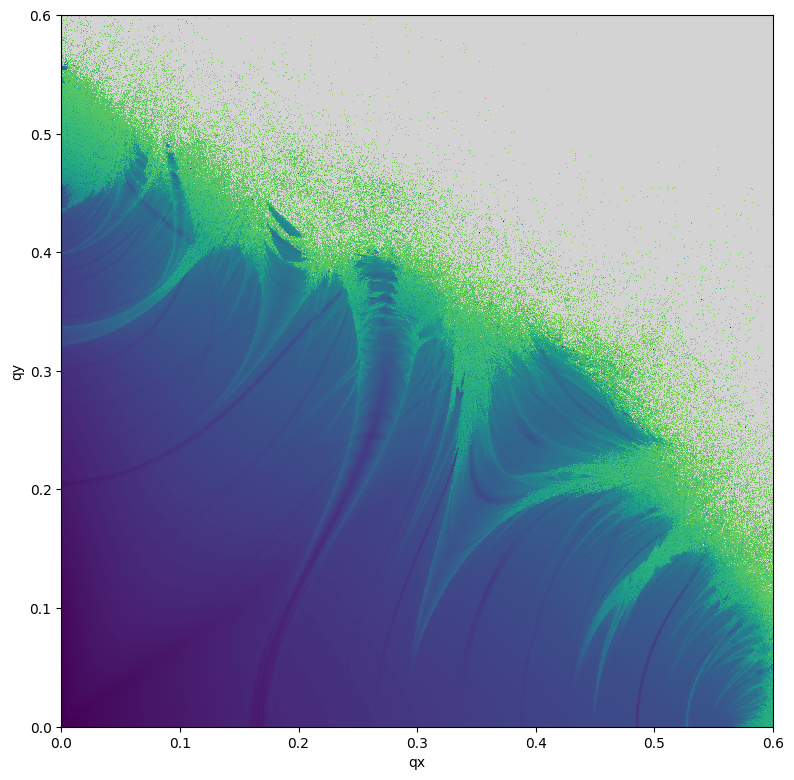

In [14]:
# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=0.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(0., 0.6, 0., 0.6))
plt.xlabel('qx')
plt.ylabel('qy')
plt.tight_layout()
plt.show()